## Import

In [1]:
import gtsam
from gtsam.utils import plot as gtsam_plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import open3d as o3d
from tqdm import tqdm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Util

In [ ]:
def create_se3_transform(tx, ty, yaw):
    """
    Create a 4x4 SE(3) transformation matrix.

    Parameters:
    - yaw: Yaw angle in radians
    - translation: (tx, ty) translation components in the XY plane

    Returns:
    - transform_matrix: 4x4 homogeneous transformation matrix
    """
    cos_theta = np.cos(yaw)
    sin_theta = np.sin(yaw)

    transform_matrix = np.array(
        [
            [cos_theta, -sin_theta, 0, tx],
            [sin_theta, cos_theta, 0, ty],
            [0, 0, 1, 0],
            [0, 0, 0, 1],
        ]
    )

    return transform_matrix


def decompose_transform_matrix(transform_matrix):
    """
    Decompose a 4x4 homogeneous transformation matrix into a 9-element rotation matrix and a 3-element translation vector.

    Parameters:
    - transform_matrix: 4x4 homogeneous transformation matrix

    Returns:
    - rotation_matrix_9: 1D array of length 9 representing the rotation matrix
    - translation_vector: (tx, ty, tz) translation vector
    """

    rotation_matrix_3x3 = transform_matrix[:3, :3] / np.linalg.det(
        transform_matrix[:3, :3]
    )
    translation_vector = transform_matrix[:3, 3]
    # Flatten the 3x3 rotation matrix to a 1D array
    rotation_matrix_9 = rotation_matrix_3x3
    # normalise the rotation matrix
    # rotation_matrix_9 = rotation_matrix_9 / np.linalg.norm(rotation_matrix_9)

    return rotation_matrix_9, translation_vector


import copy


def get_pcd(arr):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(arr[:, 0:3])
    return pcd


def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries(
        [source_temp, target_temp], point_show_normal=True
    )

def icp(init_pcd, final_pcd):
    max_correspondence_distance_ransac= 100

    init_pcd = init_pcd.voxel_down_sample(voxel_size=0.1)
    final_pcd = final_pcd.voxel_down_sample(voxel_size=0.1)

    init_pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=5, max_nn=500)
    )
    final_pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=5, max_nn=500)
    )

    source_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        init_pcd, o3d.geometry.KDTreeSearchParamHybrid(radius=50, max_nn=500)
    )

    target_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        final_pcd,
        o3d.geometry.KDTreeSearchParamHybrid(radius=50, max_nn=500),
    )

    ransac_result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        init_pcd,
        final_pcd,
        source_fpfh,
        target_fpfh,
        True,
        max_correspondence_distance_ransac,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        100,
        [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.1),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
                max_correspondence_distance_ransac
            ),
        ],
        o3d.pipelines.registration.RANSACConvergenceCriteria(1000000, 0.999),
    )

    tf = o3d.pipelines.registration.registration_icp(
        init_pcd,
        final_pcd,
        0.05,
        np.array(ransac_result.transformation),
        # np.identity(4),
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=10000),
    )
    return tf.transformation

## Load Data

In [2]:
# read the factor graph from cvs file
select = "odom"

base_path = "/media/baymax/1A52-86C0/new"

df_1_gt = pd.read_csv(f'{base_path}/detected_loops/pose_data/sync/gt/1.csv', sep=" ", header=None)
df_2_gt = pd.read_csv(f'{base_path}/detected_loops/pose_data/sync/gt/2.csv', sep=" ", header=None)
df_3_gt = pd.read_csv(f'{base_path}/detected_loops/pose_data/sync/gt/3.csv', sep=" ", header=None)
df_4_gt = pd.read_csv(f'{base_path}/detected_loops/pose_data/sync/gt/4.csv', sep=" ", header=None)

df_1 = pd.read_csv(f'{base_path}/detected_loops/pose_data/sync/{select}/1.csv', sep =" ", header=None)
df_2 = pd.read_csv(f'{base_path}/detected_loops/pose_data/sync/{select}/2.csv', sep =" ", header=None)
df_3 = pd.read_csv(f'{base_path}/detected_loops/pose_data/sync/{select}/3.csv', sep =" ", header=None)
df_4 = pd.read_csv(f'{base_path}/detected_loops/pose_data/sync/{select}/4.csv', sep =" ", header=None)

In [3]:
# convert to numpy array
arr_1_gt = df_1_gt.to_numpy()
arr_2_gt = df_2_gt.to_numpy()
arr_3_gt = df_3_gt.to_numpy()
arr_4_gt = df_4_gt.to_numpy()

arr_1 = df_1.to_numpy()
arr_2 = df_2.to_numpy()
arr_3 = df_3.to_numpy()
arr_4 = df_4.to_numpy()

In [4]:
print(arr_1_gt.shape)
print(arr_2_gt.shape)
print(arr_3_gt.shape)
print(arr_4_gt.shape)

print(arr_1.shape)
print(arr_2.shape)
print(arr_3.shape)
print(arr_4.shape)

(491, 8)
(314, 8)
(188, 8)
(424, 8)
(491, 8)
(314, 8)
(188, 8)
(424, 8)


## Factor Graph

In [6]:
# save poses in gt_estimate

gt_estimate = gtsam.Values()
for i in range(len(arr_1_gt)):
    pose = gtsam.Pose3(
        gtsam.Rot3.Quaternion(
            arr_1_gt[i][7], arr_1_gt[i][4], arr_1_gt[i][5], arr_1_gt[i][6]
        ),
        gtsam.Point3(arr_1_gt[i][1], arr_1_gt[i][2], arr_1_gt[i][3]),
    )
    gt_estimate.insert(gtsam.symbol("a", i), pose)

for i in range(len(arr_2_gt)):
    pose = gtsam.Pose3(
        gtsam.Rot3.Quaternion(
            arr_2_gt[i][7], arr_2_gt[i][4], arr_2_gt[i][5], arr_2_gt[i][6]
        ),
        gtsam.Point3(arr_2_gt[i][1], arr_2_gt[i][2], arr_2_gt[i][3]),
    )
    gt_estimate.insert(gtsam.symbol("b", i), pose)

for i in range(len(arr_3_gt)):
    pose = gtsam.Pose3(
        gtsam.Rot3.Quaternion(
            arr_3_gt[i][7], arr_3_gt[i][4], arr_3_gt[i][5], arr_3_gt[i][6]
        ),
        gtsam.Point3(arr_3_gt[i][1], arr_3_gt[i][2], arr_3_gt[i][3]),
    )
    gt_estimate.insert(gtsam.symbol("c", i), pose)

for i in range(len(arr_4_gt)):
    pose = gtsam.Pose3(
        gtsam.Rot3.Quaternion(
            arr_4_gt[i][7], arr_4_gt[i][4], arr_4_gt[i][5], arr_4_gt[i][6]
        ),
        gtsam.Point3(arr_4_gt[i][1], arr_4_gt[i][2], arr_4_gt[i][3]),
    )
    gt_estimate.insert(gtsam.symbol("d", i), pose)

### Here gtsam is only used as a wrapper to get transforms and not for optimization

In [7]:
graph = gtsam.NonlinearFactorGraph()
initial_estimate = gtsam.Values()

# add prior factor
prior_noise = gtsam.noiseModel.Diagonal.Sigmas(
    [1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8]
)

noise_odom = gtsam.noiseModel.Diagonal.Sigmas([0.01, 0.01, 0.01, 0.05, 0.05, 0.05])
noise_loop = gtsam.noiseModel.Diagonal.Sigmas(
    [0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
)

# To give initial transforms b/w robots (approximate)
tf_1 = gtsam.Pose3(gtsam.Rot3(), gtsam.Point3(0, 0, 0))
tf_2 = gtsam.Pose3(gtsam.Rot3(), gtsam.Point3(0, 0, 0))
tf_3 = gtsam.Pose3(gtsam.Rot3(), gtsam.Point3(0, 0, 0))
tf_4 = gtsam.Pose3(gtsam.Rot3(), gtsam.Point3(0, 0, 0))

# Adding Prior Factor
graph.add(
    gtsam.PriorFactorPose3(
        gtsam.symbol("a", 0),
        gtsam.Pose3(
            gtsam.Rot3.Quaternion(arr_1[0][7], arr_1[0][4], arr_1[0][5], arr_1[0][6]),
            gtsam.Point3(arr_1[0][1], arr_1[0][2], arr_1[0][3]),
        ),
        prior_noise,
    )
)


max_correspondence_distance_ransac = 1000

init_pcd = np.load(f'{base_path}/detected_loops/pcd_data/sync/{select}/1.npy')
final_pcd = np.load(f'{base_path}/detected_loops/pcd_data/sync/{select}/2.npy')
init_pcd = init_pcd[init_pcd[:, 2] > 0.05]
final_pcd = final_pcd[final_pcd[:, 2] > 0.05]

init_pcd = get_pcd(init_pcd)
final_pcd = get_pcd(final_pcd)


#  GTSAM ROT QUAT INPUT is qw, wx, qy, qz

for i in range(len(arr_1)- 1):
    key = gtsam.symbol("a", i)
    next_key = gtsam.symbol("a", i + 1)

    #load the pcd from npy
    init_pcd = np.load(f'{base_path}/detected_loops/pcd_data/sync/1/{i+1}.npy')
    final_pcd = np.load(f'{base_path}/detected_loops/pcd_data/sync/1/{i+2}.npy')
    tf = icp(init_pcd, final_pcd)

    rot, t = decompose_transform_matrix(tf)
    r = rot.flatten()
    pose_tf = gtsam.Pose3(
        gtsam.Rot3(r[0], r[1], r[2], r[3], r[4], r[5], r[6], r[7], r[8]),
        gtsam.Point3(t[0], t[1], t[2]),
    )
    graph.add(
        gtsam.BetweenFactorPose3(key, next_key, pose_tf, noise_odom)
    )
    if i == 0:
        initial_estimate.insert(key, tf_1 * pose)
    initial_estimate.insert(next_key, tf_1 * pose_next)

In [9]:
#add ICP loop closures here
symbol_dict = {1: 'a', 2: 'b', 3: 'c', 4: 'd'}

#base_link to velodyne transform
tf_sen = gtsam.Pose3(gtsam.Rot3(), gtsam.Point3(0.0812, 0.0, 0.0))

## Loop Closures

In [12]:
# # loop registration using ICP given loops detection is already done

ransac_n = 20  # Minimum number of correspondences to estimate a transformation
max_correspondence_distance_ransac = 10000  # Maximum correspondence distance for RANSAC


df_train = pd.read_csv("/media/baymax/1A52-86C0/new/detected_loops/trained_loops.txt")

pcd_basepath = "/media/baymax/1A52-86C0/new/detected_loops/pose_data/sync/pcd"

# # print(len(df_train))
for i in tqdm(range(len(df_train))):
    initial = df_train.iloc[i, 0].split(".")[0]
    final = df_train.iloc[i, 1].split(".")[0]

    if i%100 == 0 or (initial[0] != final[0] and i%20==0):
        # print(initial, final)
        init_pcd = np.load(f"{pcd_basepath}/{initial}.npy")
        final_pcd = np.load(f"{pcd_basepath}/{final}.npy")

        # print(init_pcd.shape)

        init_pcd = init_pcd[init_pcd[:, 2] > 0.05]
        final_pcd = final_pcd[final_pcd[:, 2] > 0.05]

        init_pcd = get_pcd(init_pcd)
        final_pcd = get_pcd(final_pcd)

        init_pcd = init_pcd.voxel_down_sample(voxel_size=0.1)
        final_pcd = final_pcd.voxel_down_sample(voxel_size=0.1)

        init_pcd.estimate_normals(
            search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=5, max_nn=500)
        )
        final_pcd.estimate_normals(
            search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=5, max_nn=500)
        )

        source_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
            init_pcd, o3d.geometry.KDTreeSearchParamHybrid(radius=50, max_nn=500)
        )

        target_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
            final_pcd,
            o3d.geometry.KDTreeSearchParamHybrid(radius=50, max_nn=500),
        )

        ransac_result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
            init_pcd,
            final_pcd,
            source_fpfh,
            target_fpfh,
            True,
            max_correspondence_distance_ransac,
            o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
            100,
            [
                o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.1),
                o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
                    max_correspondence_distance_ransac
                ),
            ],
            o3d.pipelines.registration.RANSACConvergenceCriteria(1000000, 0.999),
        )

        tf = o3d.pipelines.registration.registration_icp(
            init_pcd,
            final_pcd,
            0.05,
            np.array(ransac_result.transformation),
            # np.identity(4),
            o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
            o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=10000),
        )

        rot, t = decompose_transform_matrix(tf.transformation)
        r = rot.flatten()
        loop_tf = gtsam.Pose3(
            gtsam.Rot3(r[0], r[1], r[2], r[3], r[4], r[5], r[6], r[7], r[8]),
            gtsam.Point3(t[0], t[1], t[2]),
        )

        # print(
        #     symbol_dict[int(initial[0])],
        #     int(initial[2:].split("_")[0]) - 1,
        #     symbol_dict[int(final[0])],
        #     int(final[2:].split("_")[0]) - 1,
        #     np.linalg.det(rot),
        #     t,
        # )

        # vis tf in open3d
        # o3d.visualization.draw_geometries([init_pcd, tf_pcd])
        # draw_registration_result(init_pcd, final_pcd, tf.transformation)

        # source_temp = copy.deepcopy(init_pcd)
        # target_temp = copy.deepcopy(final_pcd)
        # source_temp.paint_uniform_color([1, 0.706, 0])
        # target_temp.paint_uniform_color([0, 0.651, 0.929])
        # source_temp.transform(tf.transformation)

        # # Get the corresponding points
        # source_points = np.asarray(init_pcd.points)[np.array(ransac_result.correspondence_set)[:, 0]]
        # target_points = np.asarray(final_pcd.points)[np.array(ransac_result.correspondence_set)[:, 1]]

        # Create lines between corresponding points
        # lines = []
        # for i in range(len(source_points)):
        #     lines.append([source_points[i], target_points[i]])

        # # Convert lines to Open3D line set
        # line_set = o3d.geometry.LineSet()
        # line_set.points = o3d.utility.Vector3dVector(np.vstack(lines))
        # # print(np.vstack(lines).shape)
        # line_set.lines = o3d.utility.Vector2iVector(np.arange(2*len(lines)).reshape(-1, 2))


        # o3d.visualization.draw_geometries([init_pcd, final_pcd, line_set], point_show_normal = True, window_name="ICP")
        # o3d.visualization.draw_geometries([init_pcd, final_pcd], window_name=f"{initial} to {final}")

        # # Get the corresponding points
        # source_points = np.asarray(source_temp.points)[np.array(ransac_result.correspondence_set)[:, 0]]
        # target_points = np.asarray(target_temp.points)[np.array(ransac_result.correspondence_set)[:, 1]]

        # lines = []
        # for i in range(len(source_points)):
        #     lines.append([source_points[i], target_points[i]])

        # # Convert lines to Open3D line set
        # line_set = o3d.geometry.LineSet()
        # line_set.points = o3d.utility.Vector3dVector(np.vstack(lines))
        # # print(np.vstack(lines).shape)
        # line_set.lines = o3d.utility.Vector2iVector(np.arange(2*len(lines)).reshape(-1, 2))

        # o3d.visualization.draw_geometries([source_temp, target_temp, line_set], window_name="ICP")

        graph.add(
            gtsam.BetweenFactorPose3(
                gtsam.symbol(
                    symbol_dict[int(initial[0])], int(initial[2:].split("_")[0]) - 1
                ),
                gtsam.symbol(
                    symbol_dict[int(final[0])], int(final[2:].split("_")[0]) - 1
                ),
                tf_sen * loop_tf * tf_sen.inverse(),
                noise_loop,
            )
        )
        # breaks
        # print(tf.transformation,"\n\n" ,rot, t)

  0%|          | 0/8183 [00:00<?, ?it/s]

100%|██████████| 8183/8183 [00:46<00:00, 175.68it/s]


## Optimize

In [17]:
# optimize

# params = gtsam.LevenbergMarquardtParams()
# optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate, params)
# result = optimizer.optimize()

#set inliers (odometry edges)
inliers = gtsam.KeyVector()
for i in range(0,len(arr_1)+len(arr_2)+len(arr_3)+len(arr_4)-4):
    inliers.append(i)

# gnc optimizer
paramsLM = gtsam.GncLMParams()
# paramsLM.setKnownInliers(inliers)
optimizer = gtsam.GncLMOptimizer(graph, initial_estimate, paramsLM)
result = optimizer.optimize()

## Save Optimized Poses

In [18]:
# extract optimized poses into numpy array and save into csv file with same input format
poses_1 = []
poses_2 = []
poses_3 = []
poses_4 = []

for key in result.keys():
    log = int(math.log10(key))
    key_ = int(key / (10 ** (log - 1)))

    if key_ == 69:
        poses_1.append(
            [
                int(key - gtsam.symbol("a", 0) + 1),
                result.atPose3(key).x(),
                result.atPose3(key).y(),
                result.atPose3(key).z(),
                result.atPose3(key).rotation().toQuaternion().x(),
                result.atPose3(key).rotation().toQuaternion().y(),
                result.atPose3(key).rotation().toQuaternion().z(),
                result.atPose3(key).rotation().toQuaternion().w(),
            ]
        )

    if key_ == 70:
        poses_2.append(
            [
                int(key - gtsam.symbol("b", 0) + 1),
                result.atPose3(key).x(),
                result.atPose3(key).y(),
                result.atPose3(key).z(),
                result.atPose3(key).rotation().toQuaternion().x(),
                result.atPose3(key).rotation().toQuaternion().y(),
                result.atPose3(key).rotation().toQuaternion().z(),
                result.atPose3(key).rotation().toQuaternion().w(),
            ]
        )

    if key_ == 71:
        poses_3.append(
            [
                int(key - gtsam.symbol("c", 0) + 1),
                result.atPose3(key).x(),
                result.atPose3(key).y(),
                result.atPose3(key).z(),
                result.atPose3(key).rotation().toQuaternion().x(),
                result.atPose3(key).rotation().toQuaternion().y(),
                result.atPose3(key).rotation().toQuaternion().z(),
                result.atPose3(key).rotation().toQuaternion().w(),
            ]
        )

    if key_ == 72:
        poses_4.append(
            [
                int(key - gtsam.symbol("d", 0) + 1),
                result.atPose3(key).x(),
                result.atPose3(key).y(),
                result.atPose3(key).z(),
                result.atPose3(key).rotation().toQuaternion().x(),
                result.atPose3(key).rotation().toQuaternion().y(),
                result.atPose3(key).rotation().toQuaternion().z(),
                result.atPose3(key).rotation().toQuaternion().w(),
            ]
        )

poses_1_np = np.array(poses_1)
poses_2_np = np.array(poses_2)
poses_3_np = np.array(poses_3)
poses_4_np = np.array(poses_4)

# save to csv
df_1 = pd.DataFrame(
    data=poses_1_np,
)
csv_file_path = f"{base_path}/detected_loops/pose_data/sync/optimized/1.csv"
df_1.to_csv(csv_file_path, sep=" ", index=False, header=False)

df_2 = pd.DataFrame(
    data=poses_2_np,
)
csv_file_path = f"{base_path}/detected_loops/pose_data/sync/optimized/2.csv"
df_2.to_csv(csv_file_path, sep=" ", index=False, header=False)

df_3 = pd.DataFrame(data=poses_3_np)
csv_file_path = f"{base_path}/detected_loops/pose_data/sync/optimized/3.csv"
df_3.to_csv(csv_file_path, sep=" ", index=False, header=False)

df_4 = pd.DataFrame(data=poses_4_np)
csv_file_path = f"{base_path}/detected_loops/pose_data/sync/optimized/4.csv"
df_4.to_csv(csv_file_path, sep=" ", index=False, header=False)

## Visualize

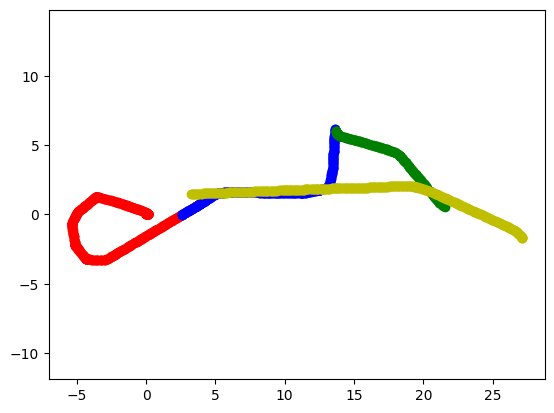

In [19]:
plt.axis('equal')
plt.scatter(arr_1[:, 1], arr_1[:, 2], c="r", label="1")
plt.scatter(arr_2[:, 1], arr_2[:, 2], c="b", label="2")
plt.scatter(arr_3[:, 1], arr_3[:, 2], c="g", label="3")
plt.scatter(arr_4[:, 1], arr_4[:, 2], c="y", label="4")
# plt.scatter(poses_1_np[:, 1], poses_1_np[:, 2], c="purple", label="1")
# plt.scatter(poses_2_np[:, 1], poses_2_np[:, 2], c="cyan", label="2")
# plt.scatter(poses_3_np[:, 1], poses_3_np[:, 2], c="orange", label="3")
# plt.scatter(poses_4_np[:, 1], poses_4_np[:, 2], c="violet", label="4")

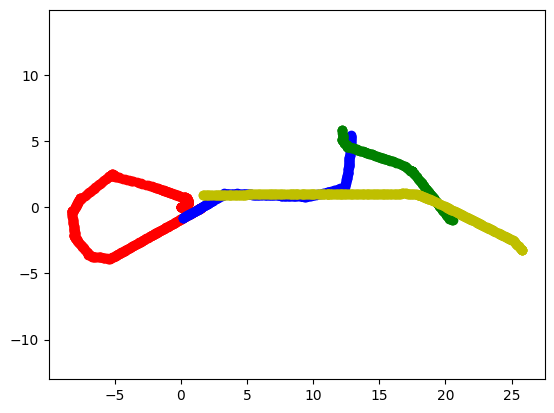

In [20]:
plt.axis('equal')
plt.scatter(arr_1_gt[:, 1], arr_1_gt[:, 2], c='r', label='1')
plt.scatter(arr_2_gt[:, 1], arr_2_gt[:, 2], c='b', label='2')
plt.scatter(arr_3_gt[:, 1], arr_3_gt[:, 2], c='g', label='3')
plt.scatter(arr_4_gt[:, 1], arr_4_gt[:, 2], c='y', label='4')

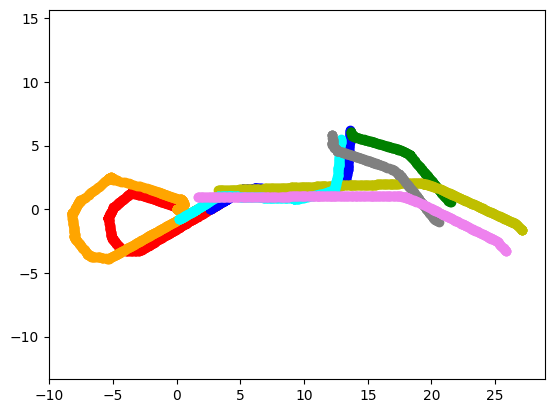

In [21]:
plt.axis('equal')
plt.scatter(arr_1[:, 1], arr_1[:, 2], c="r", label="1")
plt.scatter(arr_2[:, 1], arr_2[:, 2], c="b", label="2")
plt.scatter(arr_3[:, 1], arr_3[:, 2], c="g", label="3")
plt.scatter(arr_4[:, 1], arr_4[:, 2], c="y", label="4")
plt.scatter(arr_1_gt[:, 1], arr_1_gt[:, 2], c="orange", label="1")
plt.scatter(arr_2_gt[:, 1], arr_2_gt[:, 2], c="cyan", label="2")
plt.scatter(arr_3_gt[:, 1], arr_3_gt[:, 2], c="grey", label="3")
plt.scatter(arr_4_gt[:, 1], arr_4_gt[:, 2], c="violet", label="4")

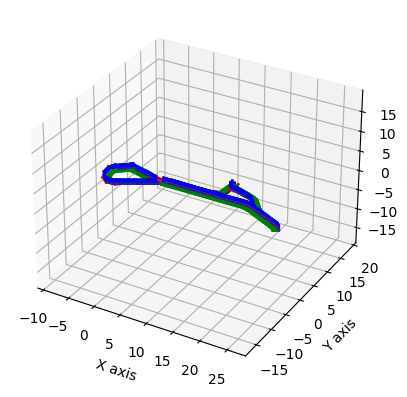

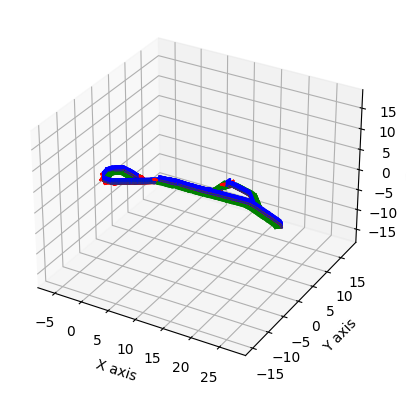

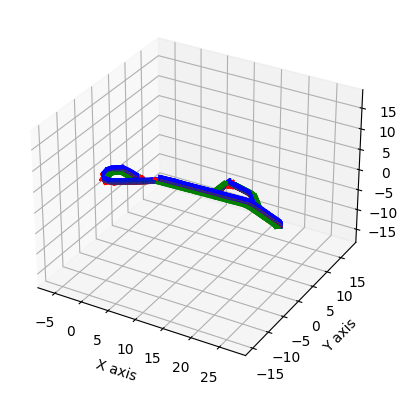

In [22]:
gtsam_plot.plot_incremental_trajectory(1, gt_estimate, time_interval=10)
plt.show()
gtsam_plot.plot_incremental_trajectory(1, result, time_interval=0.01)
plt.show()
gtsam_plot.plot_incremental_trajectory(1, initial_estimate, time_interval=0.01)
plt.show()

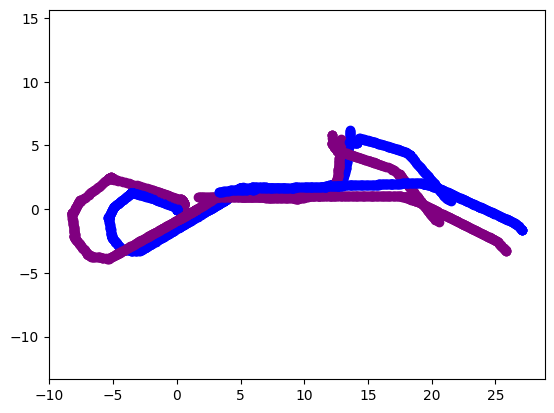

In [23]:
plt.axis('equal')
for i in initial_estimate.keys():
    # plt.scatter(initial_estimate.atPose3(i).x(), initial_estimate.atPose3(i).y(), c="r")
    plt.scatter(result.atPose3(i).x(), result.atPose3(i).y(), c="b")
    plt.scatter(gt_estimate.atPose3(i).x(), gt_estimate.atPose3(i).y(), c='purple')

In [27]:
last_key = None
for i in initial_estimate.keys():
    if last_key != None:
        print(initial_estimate.atPose3(last_key).between(initial_estimate.atPose3(i)))
    last_key = i

R: [
	1, -2.00115e-09, 0;
	2.00115e-09, 1, 0;
	0, 0, 1
]
t: 2.07935e-07 2.97601e-16           0

R: [
	1, -1.79535e-10, 0;
	1.79535e-10, 1, 0;
	0, 0, 1
]
t:  2.08242e-07 -7.48576e-17            0

R: [
	1, -2.00395e-09, 0;
	2.00395e-09, 1, 0;
	0, 0, 1
]
t:  4.1738e-07 9.34388e-16           0

R: [
	1, -1.36166e-08, 0;
	1.36166e-08, 1, 0;
	0, 0, 1
]
t: 2.09134e-07  1.4425e-15           0

R: [
	1, -1.9058e-08, 0;
	1.9058e-08, 1, 0;
	0, 0, 1
]
t: 9.79829e-07 8.89505e-15           0

R: [
	1, -1.57679e-08, 0;
	1.57679e-08, 1, 0;
	0, 0, 1
]
t: 2.10785e-07 1.25841e-15           0

R: [
	1, -5.70595e-09, 0;
	5.70595e-09, 1, 0;
	0, 0, 1
]
t: 2.11072e-07 8.26038e-16           0

R: [
	1, -9.45897e-09, 0;
	9.45897e-09, 1, 0;
	0, 0, 1
]
t: 5.64255e-07 4.73628e-15           0

R: [
	1, -2.83482e-08, 0;
	2.83482e-08, 1, 0;
	0, 0, 1
]
t: 5.69432e-07 8.37988e-15           0

R: [
	1, -7.57457e-09, 0;
	7.57457e-09, 1, 0;
	0, 0, 1
]
t:  3.50689e-07 -1.23381e-15            0

R: [
	1, -2.07595e-09, 0;


## Save Graph to PDF

Not visible due to large number of nodes

In [32]:
graph.saveGraph("test.dot", result)
import graphviz

graphviz.Source.from_file("test.dot").view()

'test.dot.pdf'


(process:1098683): Gtk-WARNING **: 17:39:47.059: Locale not supported by C library.
	Using the fallback 'C' locale.

(evince:1098683): Gtk-WARNING **: 17:39:47.106: Theme parsing error: gtk-keys.css:1:0: Failed to import: Error opening file /snap/code/143/usr/share/themes/Default/gtk-3.0/gtk-keys.css: Permission denied
Gtk-Message: 17:39:47.106: Failed to load module "canberra-gtk-module"
Gtk-Message: 17:39:47.109: Failed to load module "canberra-gtk-module"
/home/baymax/snap/code/common/.cache/gio-modules/libdconfsettings.so: cannot open shared object file: Permission denied
Failed to load module: /home/baymax/snap/code/common/.cache/gio-modules/libdconfsettings.so

(evince:1098683): Gtk-WARNING **: 17:39:47.173: Could not load a pixbuf from icon theme.
This may indicate that pixbuf loaders or the mime database could not be found.
**
Gtk:ERROR:../../../../gtk/gtkiconhelper.c:494:ensure_surface_for_gicon: assertion failed (error == NULL): Failed to load /usr/share/icons/Yaru/48x48/sta

Bail out! Gtk:ERROR:../../../../gtk/gtkiconhelper.c:494:ensure_surface_for_gicon: assertion failed (error == NULL): Failed to load /usr/share/icons/Yaru/48x48/status/image-missing.png: Unable to load image-loading module: /snap/code/143/usr/lib/x86_64-linux-gnu/gdk-pixbuf-2.0/2.10.0/loaders/libpixbufloader-png.so: /snap/code/143/usr/lib/x86_64-linux-gnu/gdk-pixbuf-2.0/2.10.0/loaders/libpixbufloader-png.so: cannot open shared object file: Permission denied (gdk-pixbuf-error-quark, 5)
